# XGB-FNN预测

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sqlalchemy import create_engine
from xgboost import XGBRegressor
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

## 导入数据

In [2]:
url = '../dataset_0101110000.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## 归一化

In [3]:
# 归一化
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    normalized_data = MinMaxScaler().fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[['load']])
    return normalized_data, scaler_y

## 构建监督学习数据集

In [4]:
# build supervised data
def Series_To_Supervise(data, seq_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - 24
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, 24))
    for i in range(0, dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + 24, y_col_index]
    print("Supervised Train Data: Shape of x: {}, Shape of y: {}".format(
        x.shape, y.shape))
    return x, y


def Series_To_Supervise_Test(data, seq_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = int((data.shape[0] - seq_len - 24) / 24) + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, 24))
    for i in range(0, dim_0):
        x[i] = data[i * 24:i * 24 + seq_len]
        y[i] = data[i * 24 + seq_len:i * 24 + seq_len + 24, y_col_index]
    print("Supervised Test Data: Shape of x: {}, Shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 五折交叉验证

In [5]:
# 5-fold cross-validation
def split_dataset(X, Y, n_split=5):
    """
    X: original feature, size * 72 * features
    Y: labels, size * 1
    return: list of train_x, test_x, train_y, test_y
    """
    kf = KFold(n_splits=n_split, shuffle=True, random_state=1)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in kf.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, valid_x_list, train_y_list, valid_y_list

## 定义FNN模型

In [6]:
# define FNN model
class FNN(nn.Module):
    """
    A fnn neural network
    """
    def __init__(self, input_size, hidden_dim):
        super(FNN, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(input_size, 250),
            nn.ReLU(),
            nn.Linear(250, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 24),
            nn.ReLU(),
        )

    def forward(self, x):
        out = self.fnn(x)
        return out

## 训练模型函数

In [7]:
# train the model
def Train_Model(train_x_list, train_y_list, valid_x_list, valid_y_list,
                batch_size, lr, number_epoch, input_size, hidden_dim, seq_len):
    model_fnn = FNN(input_size, hidden_dim)
    model_fnn.to(device=device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_fnn.parameters(), lr=lr)
    valid_loss_min = np.Inf
    for i in range(5):
        print('train dataset {}'.format(i))
        train_x = train_x_list[i]
        train_y = train_y_list[i]
        valid_x = valid_x_list[i]
        valid_y = valid_y_list[i]
        train_x = train_x.reshape(train_x.shape[0], -1)
        valid_x = valid_x.reshape(valid_x.shape[0], -1)
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        num_without_imp = 0
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader), total=len(train_loader))
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs = model_fnn(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if i % 10 == 0:
                    # if num_without_imp > 30:
                    #     return model_fnn
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model_fnn.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = model_fnn(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())

                    model_fnn.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model_fnn.state_dict(), "fnn_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
    return model_fnn

## 测试模型函数

In [8]:
# test model by day
def Test_Model_24(model, test_x, test_y, batch_size, seq_len, y_col_index,
                  scaler):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False)
    model.load_state_dict(torch.load('fnn_state_dict.pt'))
    size = 24
    y_pred = list()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device=device)
            inp = inputs.reshape(inputs.shape[0], -1)
            out = model(inp)
            y_pred = y_pred + out.cpu().numpy().tolist()
    y_pred = np.array(y_pred)
    y_true = np.array(test_y)
    y_pred = y_pred.reshape(-1, 1)
    y_true = y_true.reshape(-1, 1)
    load_pred = scaler.inverse_transform(y_pred)
    load_true = scaler.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## 超参数定义

In [9]:
# model configs
def Model_Configs():
    batch_sizes = [512]
    lrs = [0.01]
    number_epochs = [50]
    hidden_dims = [5]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    configs.append([i, j, k, l])
    return configs

## 主函数

In [10]:
def main(seq_len=48):
    # 归一化
    normalized_data, scaler_y = normalization(data)
    train_data = normalized_data
    test_data = normalized_data[-5496:]
    # 数据处理，将时间序列数据变为监督学习数据
    y_index = data.shape[1] - 1
    input_size = data.shape[1] * seq_len
    X_train, Y_train = Series_To_Supervise(train_data,
                                           seq_len=seq_len,
                                           y_col_index=y_index)

    # 五折交叉验证，划分数据集
    train_x_list, valid_x_list, train_y_list, valid_y_list = split_dataset(
        X_train, Y_train)
    test_x, test_y = Series_To_Supervise_Test(test_data,
                                              seq_len=seq_len,
                                              y_col_index=y_index)
    print("model configs set")
    configs = Model_Configs()
    MAPE_list = list()
    MAE_list = list()
    RMSE_list = list()
    for config in configs:
        batch_size = config[0]
        lr = config[1]
        number_epoch = config[2]
        hidden_dim = config[3]
        print(
            "Config: batch_size--{}, lr--{}, number_epoch--{}, hidden_dim--{}".
            format(config[0], config[1], config[2], config[3]))
        while (1):
            model = Train_Model(
                train_x_list,
                train_y_list,
                valid_x_list,
                valid_y_list,
                batch_size,
                lr,
                number_epoch,
                input_size=input_size,
                hidden_dim=hidden_dim,
                seq_len=seq_len,
            )
            MAPE, MAE, RMSE, load_pred, load_true = Test_Model_24(
                model,
                test_x,
                test_y,
                batch_size,
                seq_len,
                y_col_index=y_index,
                scaler=scaler_y)
            if MAPE < 1:
                break
        MAPE_list.append(MAPE)
        MAE_list.append(MAE)
        RMSE_list.append(RMSE)
    return (MAPE_list, MAE_list, RMSE_list, load_pred, load_true, model)

In [14]:
(MAPE_list, MAE_list, RMSE_list, load_pred, load_true, model) = main()

Supervised Train Data: Shape of x: (31587, 48, 23), Shape of y: (31587, 24)
Supervised Test Data: Shape of x: (227, 48, 23), Shape of y: (227, 24)
model configs set
Config: batch_size--512, lr--0.01, number_epoch--50, hidden_dim--5
train dataset 0


Epoch: 50/50...: 100%|██████████| 50/50 [00:01<00:00, 38.73it/s, train_loss=0.0162, valid_loss=0.016]


train dataset 1


Epoch: 50/50...: 100%|██████████| 50/50 [00:01<00:00, 43.27it/s, train_loss=0.0093, valid_loss=0.00906] 


train dataset 2


Epoch: 50/50...: 100%|██████████| 50/50 [00:01<00:00, 40.91it/s, train_loss=0.0014, valid_loss=0.00156] 


train dataset 3


Epoch: 50/50...: 100%|██████████| 50/50 [00:00<00:00, 51.65it/s, train_loss=0.00146, valid_loss=0.00136]


train dataset 4


Epoch: 50/50...: 100%|██████████| 50/50 [00:00<00:00, 52.13it/s, train_loss=0.00145, valid_loss=0.00143]


In [12]:
MAPE_list, MAE_list, RMSE_list

([0.07489882796990989], [994.782615369872], [2237.311488580672])

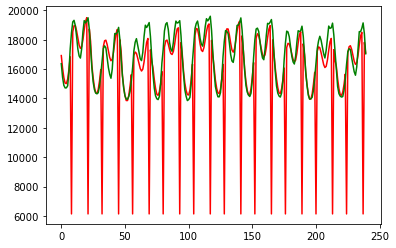

In [13]:
plt.plot(load_pred[0:240], 'r')
plt.plot(load_true[0:240], 'g')